# **AIML CA2 Assignment - Part A (Clustering)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---

### **Tasks, and how I fulfilled them**
##### → _"Include some tests of your clustering with different possible values of k."_
  - PCA (Principal Component Analysis) for a range of k-values
  - t-SNE (T-distributed Stochastic Neighbour Embedding) for a range of perplexities and learning rates.
  - Dendrogram
  - 2D Scatter Plot

##### → _"Determine the best possible value of k. And show how you can determine that this is the best value for k."_  
  - Elbow Method
  - Silhouette Score
  - Silhouette Plot
  - Davies Bouldin Index
  - Calinski-Harabasz Score

##### → _"Use more than just one clustering algorithm (so, not just k-means)."_
  - Agglomerative Clustering
  - KMeans

### **Machine Learning Workflow**
1. EDA
2. Data Preprocessing 
3. Feature Engineering 
4. Employing Clustering Algorithms
5. Model Evaluation
6. Interpretation / Conclusion

---

### Import Libraries

In [ ]:
# Data Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Model training
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Shape**: Dataset has X rows and Y columns.
* **Info & Summary Statistics**: Analyse data types, non-missing counts, and key statistics (mean, standard deviation, etc.) for numerical columns.
* **Investigate Irregular Data**: Use intuition to identify and resolve irregular data like negative prices or abnormally large Age values.
* **Visualise Distributions**: Perform univariate and bivariate analysis using matplotlib and seaborn to identify patterns.
* **Missing Values**: Identify missing values per column / overall.

### Load & Preview Dataset

In [ ]:
df = pd.read_csv("./CA2-datasets/CA2-Customer-Data.csv")
df.head()

In [ ]:
print(f"rows: {df.shape[0]}, cols: {df.shape[1]}")

### Investigate Irregularities in Dataset

#### dtypes

In [ ]:
df.info()

* No necessary edits needed for column dtypes

#### Features (numerical then categorical)

In [ ]:
df.describe()

* Mean `Age` is ~39  

* Mean `Income (k$)` is ~60.6k$  

* #### **Key Observation:** `How Much They Spend` has no labelled unit, and interestingly ranges from 1.0 to 99.0. This suggests that this feature could represent a "spending score" of 1-99 instead of raw "money spent".

In [ ]:
df.describe(include='O')

* `Gender` shows an imbalance (112 Females : 88 Males), might influence our clusters later on

#### Investigate `How Much They Spend`
Intuitively, this feature would represent the amount of money spent by each customer. However, the range of this feature is only between 1 - 99, which is strange as real-world data rarely caps at 99 so cleanly.  
We will investigate the feature's distributions to see whether it represents an engineered score between 1-99 or not.  

Key Assumptions:
* Real-world money data should be right-skewed
* Richer customers should have higher input values for this feature

##### 1. Distributions of `How Much They Spend`

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# histogram
sns.histplot(df["How Much They Spend"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Spending")
axes[0].set_xlabel("How Much They Spend")
axes[0].set_ylabel("Count")

# boxplot
sns.boxplot(x=df["How Much They Spend"], ax=axes[1])
axes[1].set_title("Spending Boxplot")
axes[1].set_xlabel("How Much They Spend")

plt.tight_layout()
plt.show()

print("Median:", df["How Much They Spend"].median())
print("Q1:", df["How Much They Spend"].quantile(0.25))
print("Q3:", df["How Much They Spend"].quantile(0.75))

* How Much They Spend displays a trimodal distribution instead of a right-skew, which supports the hypothesis that it the feature represents an engineered Spending Score of 1-99 instead of a raw spending amount.

##### 2. `Income (k$)` VS `How Much They Spend`
"Do richer people tend to spend more?"

In [ ]:
# calculate correlation coefficient
corr = df["Income (k$)"].corr(df["How Much They Spend"])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Income (k$)", y="How Much They Spend")
plt.title(f"Income (k$) vs Spending (r = {corr:.2f})")
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend")
plt.tight_layout()
plt.show()

* There is a ***weak*** positive relationship between `Income (k$)` and `How Much They Spend`, suggesting that richer people do not tend to spend more.  

* The low Pearson correlation points to the fact that these features are more suitable for customer segmentation than linear prediction. Customers were naturally separated into clusters as shown from the scatter plot. For instance, all high-earning customers (Income (k$) > 70) are separated into two groups: High spending and Low spending.

* Shows that Income (k$) and How Much They Spend separates customers meaningfully (helps distinguish customer types). The clear 'X' structure formed suggests they are strong features.

##### 3. Spending by Age Group
Split customers into five specific age ranges and compare their respective spending.  

"Do older customers tend to spend less?"

In [ ]:
df["Age Group"] = pd.cut(
  df["Age"],
  bins=[17, 25, 35, 45, 55, 70]
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x="Age Group", y="How Much They Spend")
plt.title("Spending by Age Group")
plt.tight_layout()
plt.show()

* Highest spending at the 26-35years age group, indicating young working adults show the highest spending potential.

* Widest variety of spending at the 36-45years age group, suggesting strong potential for growth via targeted campaigns.

* Older folks have a wider variety of spenders, with some spending way below the average (see the minimum). However, the median (Q2) spending of the 56-70years age group is actually higher than the 36-45 and 46-55 age groups, suggesting that older folks do not spend the least.

##### Conclusion: `How Much They Spend` = `Spending Score (1-99)`

In [ ]:
df.rename(
  columns={'How Much They Spend': 'Spending Score (1-99)'},
  inplace=True
)
df.columns

#### Visualise `Age` Distribution

In [ ]:
plt.figure(figsize=(6, 4))

sns.histplot(df["Age"], bins=20, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print("Median:", df["Age"].median())
print("Q1:", df["Age"].quantile(0.25))
print("Q3:", df["Age"].quantile(0.75))

#### Visualise `Gender` Proportion

In [ ]:
# count the values in 'Gender'
gender_counts = df['Gender'].value_counts()

# bar chart
plt.figure(figsize=(6, 4))
barplot = sns.barplot(
  x=gender_counts.index, 
  y=gender_counts.values, 
  palette=['pink', 'darkblue']
)

# data labels
for i, count in enumerate(gender_counts.values):
  plt.text(i, count + 1, str(count), ha='center', fontsize=8)

plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Bivariate Analysis: Correlation Heatmap

In [ ]:
# temporarily encode categorical variable Gender
temp_df = df.copy()
temp_df['Gender'] = temp_df['Gender'].map({'Male': 0, 'Female': 1})

# get the correlation matrix for numerical columns only
correlation_matrix = temp_df.drop(columns=['CustomerID', 'Age Group']).corr()

# heatmap
plt.figure(figsize=(10, 8))                     
sns.heatmap(
  correlation_matrix, annot=True,      
  cmap='Spectral',                     
  fmt=".2f",                          
  linewidths=0.5, linecolor='gray')   
plt.title('Correlation between variables')         
plt.xticks(rotation=45)                          
plt.yticks(rotation=0)                           
plt.show()

* Age and Spending Score (1-99):
  * Negative correlation (-0.33), highlighted in red, suggests that older customers tend to spend less.

* Income and Spending Score (1-99):
  * Displays negligible correlation (0.01), represented in orange/yellow, indicating that income does not significantly influence spending patterns.

* Age and Income:
  * A weak negative correlation (-0.01) suggests no meaningful relationship between a customer's age and income level.

**Key Insights**
1. Age shows the strongest relationship with spending among the features, making it a valuable variable for customer segmentation.
2. Income and Spending Score (1-99) lack a meaningful correlation, implying income alone may not drive customer spending behaviour.
3. This analysis helps us identify which variables may be more significant when forming clusters, ensuring a focused and effective clustering approach.

### Bivariate Analysis: Pairplot

In [ ]:
pairplot = sns.pairplot(
  df,
  vars=["Age", "Income (k$)", "Spending Score (1-99)"],
  hue="Gender", # hue to highlight gender differences
  diag_kind="kde",
  palette=['blue','pink'],
  height=2.5,
)

pairplot.fig.suptitle("Pairplot of Numerical Features with Gender Hue", y=1.02, fontsize=14, fontweight="bold")
plt.show()

**Interpretation:**
* Age Distribution (Top Left)
  * Both genders show similar age distributions, with most customers falling between 20-40 years old.
  * The distributions overlap substantially, indicating the store attracts similar age groups regardless of gender. The only noteworthy difference is the maximum age for females is much higher than that of males.

* Annual Income Distribution (Center)
  * Income distributions are similar for both genders, ranging from about $15k to $140k, with most customers earning between $50k-100k. This suggests income is independent of gender in this customer base.

* Spending Score Distribution (Bottom Right)
  * Spending scores range from 1-100. Females have higher spending scores than males on average, suggesting that females spend more than males.

* Age vs Annual Income (Row 2, Column 1)
  * The scatter plot shows no clear relationship between age and income. Customers across all age groups have varied income levels, distributed fairly randomly. Gender does not appear to influence this relationship.

* Age vs Spending Score (Row 3, Column 1)
  * There is no strong correlation between age and spending behavior. However, younger customers (under 40) show the full range of spending scores, while older customers (over 50) tend to cluster in the middle spending ranges.

* Annual Income vs Spending Score (Row 3, Column 2)
  * This is the most interesting relationship. The data suggests potential customer segments: high income with high spending, high income with low spending, low income with high spending, and low income with low spending. These visible clusters could be useful for targeted marketing strategies and shows that our data already contains natural clusters. KMeans is a potential algorithm.

**Business Implications:**
* For retail startups, this data suggests that **gender-based strategies may not be necessary** since spending patterns are similar across genders. Instead, **customer segments can be identified based on their income-spending relationship**.  
* The clusters visible in the income vs spending plot indicate distinct customer groups that likely require different marketing approaches and product offerings.

### Check Missing Values

In [ ]:
df.isna().sum()

* Dataset contains no missing data.  

* Investigated and resolved column `How Much They Spend` by renaming it to `Spending Score (1-99)`.  

* No irregularities found in remaining column data (e.g. entries containing negative `Income (k$)` or huge `Age` values).  

* Dataset is ready to be preprocessed!

---

## **STAGE 2: Data Preprocessing**
* **Remove ID Features**: Drop `CustomerID`
* **Remove Duplicates**: Drop duplicate rows
* **StandardScaler**: Scale features to prevent them from dominating euclidean distance-based algorithms like KMeans
* **One-Hot Encoding**: Encode categorical features  
* **Outlier Detection with IsolationForest**: Detect extreme outliers to evaluate whether StandardScaler is suitable

### Remove ID & Duplicates

In [ ]:
df = df.drop_duplicates()
df = df.drop(columns=['CustomerID'])
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Dropped CustomerID")

### One-Hot Encoding `Gender`

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop="first")
one_hot_gender = encoder.fit_transform(df[["Gender"]])

df = df.join(
  pd.DataFrame(one_hot_gender, columns=encoder.get_feature_names_out(["Gender"]))
).drop(columns="Gender")

df.head()

### StandardScaler

In [ ]:
outlier_features = ["Age", "Income (k$)", "Spending Score (1-99)"]

# scale features and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[outlier_features])

### Investigating Outliers with IsolationForest
"How extreme are this dataset's outliers?"  
"How might the outliers affect my preprocessing steps like StandardScaler?"  
"After visualising the dataset with outliers flagged, which algorithms might struggle on this dataset?"

In [ ]:
# instantiate Isolation Forest
iso = IsolationForest(
  n_estimators=100,
  contamination=0.05,
  random_state=42
)

df['Outlier'] = iso.fit_predict(df[outlier_features])

# count outliers
n_outliers = (df['Outlier'] == -1).sum()
n_normal = (df['Outlier'] == 1).sum()

# prepare data splits
normal = df[df['Outlier'] == 1]
outliers = df[df['Outlier'] == -1] if n_outliers > 0 else None

# instantiate PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
df.head(1)

In [ ]:
# visualize outliers in both feature space and PCA space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# feature Space: Income vs Spending
axes[0].scatter(
  normal["Income (k$)"], 
  normal["Spending Score (1-99)"], 
  alpha=0.6, s=40, color='steelblue', 
  label=f'Normal (n={n_normal})', 
  edgecolors='black', linewidth=0.3
)

if n_outliers > 0:
  axes[0].scatter(
    outliers["Income (k$)"], 
    outliers["Spending Score (1-99)"], 
    alpha=0.9, s=40, color='red', marker='o',
    label=f'Outliers (n={n_outliers})', 
    edgecolors='darkred', linewidth=1.5
  )

axes[0].set_xlabel("Income (k$)", fontsize=12)
axes[0].set_ylabel("Spending Score (1-99)", fontsize=12)
axes[0].set_title("Outlier Detection: Feature Space\n(Income vs Spending)", fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# PCA Space: compressed features
normal_pca = df[df['Outlier'] == 1]
axes[1].scatter(
  normal_pca['PCA1'], 
  normal_pca['PCA2'], 
  alpha=0.6, s=40, color='steelblue', 
  label=f'Normal (n={n_normal})', 
  edgecolors='black', linewidth=0.3
)

if n_outliers > 0:
  outliers_pca = df[df['Outlier'] == -1]
  axes[1].scatter(
    outliers_pca['PCA1'], 
    outliers_pca['PCA2'], 
    alpha=0.9, s=40, color='red', marker='o',
    label=f'Outliers (n={n_outliers})', 
    edgecolors='darkred',
  )

var_explained = pca.explained_variance_ratio_
axes[1].set_xlabel(f"PC1 ({var_explained[0]*100:.1f}% variance)", fontsize=12)
axes[1].set_ylabel(f"PC2 ({var_explained[1]*100:.1f}% variance)", fontsize=12)
axes[1].set_title("Outlier Detection: PCA Space\n(Age + Income + Spending)", fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Conclude Outlier Removal

In [ ]:
if n_outliers > 0:
  comparison_df = pd.DataFrame({
    'Normal (Mean)': round(normal[outlier_features].mean(), 3),
    'Outliers (Mean)': round(outliers[outlier_features].mean(), 3),
    'Difference': round(outliers[outlier_features].mean() - normal[outlier_features].mean(), 3)
  })

df = df.drop(columns=['PCA1', 'PCA2', 'Outlier']) # clean up temporary columns

print("Outlier vs Normal Comparison:")
comparison_df

In [ ]:
outliers[outlier_features].describe().loc[["min", "max"]]

Conclusion:

"How extreme are this dataset's outliers?"  
* Not extreme, Age has a miniscule difference of -0.158 while Income and Spending Score differ by $5,516 and -15 respectively.
* I will keep outliers as they represent high-income, low-spending customers, which form a meaningful customer segment rather than data errors. Removing them would reduce the interpretability of the clustering results.

"How might the outliers affect my preprocessing steps like StandardScaler?"  
* Lack of extreme outliers suggest that StandardScaler is appropiate.

* Proves that StandardScaler is more appropiate than MinMaxScaler:
  * Outliers are behaviourally meaningful, not errors → MinMax would stretch the scale around them
  * Relative differences between customers matter
  * StandardScaler maintains cluster structure better under K-Means

"After visualising the dataset with outliers flagged, which algorithms might struggle on this dataset?"
* Algorithms like KMeans should perform well as the data showed natural clusters (see Feature Space of Income VS Spending Score)

---

## **STAGE 3: Feature Engineering**
* **Create Relationship Features**: Create features that reflect behaviours or patterns, not raw values.

### `Spending_Income_Ratio`

In [ ]:
df["Spend_Income_Ratio"] = df["Spending Score (1-99)"] / df["Income (k$)"]
df.head()

In [ ]:
sns.histplot(df['Spend_Income_Ratio'], bins=10, kde=True)

---

### **Finalise Input Features**
KMeans clustering works best when a small number of **meaningful** features are used.  
Including too many features can increase complexity and reduce the quality of the clusters formed. Therefore, features that do not contribute to clearer or more distinct clusters should be excluded.

---

#### Experiment: Include `Gender` or not?
* Use sklearn's Pipeline to streamline the model training process
* Exclude engineered features first, only include them later to ensure the clustering is actually due to Gender.

In [ ]:
features_with_gender = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  "Gender_Male"
]

##### KMeans without `Gender`

In [ ]:
preprocess_no_gender = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_gender[:-1]) # exclude the last element in the features list: Gender)
  ]
)

pipeline_no_gender = Pipeline(
  steps=[
    ("preprocess", preprocess_no_gender),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_No_Gender"] = pipeline_no_gender.fit_predict(df)

##### KMeans with `Gender`

In [ ]:
preprocess_with_gender = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_gender) # includes Gender
  ]
)

pipeline_with_gender = Pipeline(
  steps=[
    ("preprocess", preprocess_with_gender),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_With_Gender"] = pipeline_with_gender.fit_predict(df)

##### Compare Clustering

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# WITH Gender
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_With_Gender",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title("Clusters WITH Gender")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT Gender
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_No_Gender",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title("Clusters WITHOUT Gender")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

# clean up df
df = df.drop(columns=["Cluster_No_Gender", "Cluster_With_Gender"])

Conclusion: Exclude `Gender` as it does not help create more meaningful clusters and only adds noise.

---

#### Experiment: `Spend_Income_Ratio`
Is the engineered feature useful? Does it help clusters form more distinctly?

In [ ]:
features_with_ratio = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  "Spend_Income_Ratio"
]

##### KMeans without `Spend_Income_Ratio`

In [ ]:
preprocess_no_ratio = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_ratio[:-1])
  ]
)

pipeline_no_ratio = Pipeline(
  steps=[
    ("preprocess", preprocess_no_ratio),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_No_Ratio"] = pipeline_no_ratio.fit_predict(df)

##### KMeans with `Spend_Income_Ratio`

In [ ]:
preprocess_with_ratio = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_ratio)
  ]
)

pipeline_with_ratio = Pipeline(
  steps=[
    ("preprocess", preprocess_with_ratio),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_With_Ratio"] = pipeline_with_ratio.fit_predict(df)

#### Compare Clusters

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# WITH ratio 
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_With_Ratio",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title("Clusters WITH Ratio")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT Ratio
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_No_Ratio",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title("Clusters WITHOUT Ratio")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

# clean up df
df = df.drop(columns=["Cluster_No_Ratio", "Cluster_With_Ratio"])

Conclusion: Although `Spending_Income_Ratio` helped to resolve a small amount of mess/overlap in our clusters, its impact on the clustering was not substantial. Thus, I will not keep this feature as keeping it would likely just increase our model complexity.

---

### Compare Scaled VS Unscaled Data

In [ ]:
features = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  # concluded to exclude gender and spend_income_ratio
]

#### Raw/Unscaled Features
The preprocessing step in the previous pipelines on Gender and Ratio filtered out non-numeric features, preventing interval-type data from being passed into the KMeans algorithm.  
This pipeline has no preprocessor, so I have to manually pass in the features when fitting KMeans in pipeline.fit_predict().

In [ ]:
pipeline_no_scale = Pipeline(
  steps=[
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_Unscaled"] = pipeline_no_scale.fit_predict(df[features])

# calculate silhouette score
X_unscaled = df[features].values
labels_unscaled = df["Cluster_Unscaled"]
silhouette_unscaled = silhouette_score(X_unscaled, labels_unscaled)

#### Scaled Features
The preprocessor drops all the columns not specified in the list features. Thus, I do not have to manually pass in the features when fitting KMeans in pipeline.fit_predict().

In [ ]:
preprocess_with_scale = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features)
  ]
)

pipeline_with_scale = Pipeline(
  steps=[
    ("preprocess", preprocess_with_scale),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_Scaled"] = pipeline_with_scale.fit_predict(df)

# calculate silhouette score
X_scaled = pipeline_with_scale.named_steps["preprocess"].transform(df)
labels_scaled = df["Cluster_Scaled"]
silhouette_scaled = silhouette_score(X_scaled, labels_scaled)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# WITH scaling
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_Scaled",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title(f"Clusters WITH Scaled Features\nSilhouette Score:{silhouette_scaled:.2f}")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT scaling
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_Unscaled",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title(f"Clusters WITHOUT Scaled Features\nSilhouette Score: {silhouette_unscaled:.2f}")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
df.drop(columns=["Cluster_Scaled", "Cluster_Unscaled"], inplace=True)
df.head(1)

### Extract & Visualise Scaled Features

In [ ]:
X_scaled = pipeline_with_scale.named_steps["preprocess"].transform(df[features])
feature_names = pipeline_with_scale.named_steps[
  "preprocess"
].get_feature_names_out()

clean_names = [name.replace("num__", "") for name in feature_names]

X_scaled_df = pd.DataFrame(X_scaled, columns=clean_names)
X_scaled_df = X_scaled_df.add_suffix("_scaled")
df = pd.concat([df, X_scaled_df], axis=1)

#### Normalised Distribution: mean 0, std 1

In [ ]:
scaled_cols = [
  "Age_scaled",
  "Income (k$)_scaled",
  "Spending Score (1-99)_scaled"
]

plt.figure(figsize=(10, 5))
for col in scaled_cols:
  sns.histplot(df[col], kde=True, label=col, bins=30)

plt.title("Distribution of Scaled Features")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df[scaled_cols].describe().loc[['mean', 'std']]

### Analyze Finalised Features
* `Age_scaled`

* `Income (k$)_scaled`

* `Spending Score (1-99)_scaled`


#### Feature Importances

In [ ]:
# instantiate PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# calculate importance as weighted sum of absolute loadings
weights = pca.explained_variance_ratio_
feature_importance = (
  np.abs(pca.components_[0]) * weights[0] + 
  np.abs(pca.components_[1]) * weights[1]
)
importance_df = pd.DataFrame({
  'Feature': features,
  'Importance Score': feature_importance,
  'Importance (%)': (feature_importance / feature_importance.sum()) * 100
}).sort_values('Importance Score', ascending=True)

# plot bar chart
plt.figure(figsize=(10, 6))

colors = ['lightblue', 'lightgreen', 'indianred']
plt.barh(importance_df['Feature'], importance_df['Importance (%)'], color=colors, edgecolor='black')
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Overall Feature Importance for Clustering\n(Based on PC1 + PC2)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

importance_df

I would say all features are equally important for our clustering, income is only slightly more important.

#### Scree Plot for Variance Explained

In [ ]:
# instantiate PCA with 3 components to capture all variance
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

variance_df = pd.DataFrame({
  'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
  'Variance Explained (%)': pca.explained_variance_ratio_ * 100,
  'Cumulative Variance (%)': np.cumsum(pca.explained_variance_ratio_) * 100
})

# scree plot
plt.figure(figsize=(8, 6))

plt.bar(
  range(1, len(pca.explained_variance_ratio_) + 1), 
  pca.explained_variance_ratio_ * 100, 
  color='skyblue', edgecolor='black'
)
plt.plot(
  range(1, len(pca.explained_variance_ratio_) + 1), 
  np.cumsum(pca.explained_variance_ratio_) * 100, 
  color='red', marker='o', linewidth=2, label='Cumulative'
)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Variance Explained (%)', fontsize=12)
plt.title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))

print(f"\nPC1 + PC2 capture {variance_df.iloc[1]['Cumulative Variance (%)']:.1f}% of total variance")
variance_df

PC1 and PC2 already capture nearly 80% variance in data. PC3 is unnecessary.

---

## **STAGE 4: Employing Clustering Algorithms**

### Find Optimal k-value

#### Elbow Method

In [ ]:
inertia = []

for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(X_scaled)
  inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

#### Silhouette Score

![Silhouette Score Formula]("silhouette_score_formula.png")

a(i) = average distance to points in the same cluster  
b(i) = average distance to points in the nearest other cluster

In [ ]:
k_range = range(2, 10)

evaluation_metrics = {
  'silhouette': {},
  'davies_bouldin': {},
  'calinski_harabasz': {}
}

In [ ]:
for k in k_range: # check sil scores for k=2 to k=9 
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  score = silhouette_score(X_scaled, labels)
  evaluation_metrics["silhouette"][k] = round(score, 3)
  print(f"k={k}, silhouette={evaluation_metrics["silhouette"][k]}")

# plot silhouette scores vs k
plt.figure(figsize=(8, 5))
plt.plot(k_range, evaluation_metrics["silhouette"].values(), marker='o', linestyle='-', color='purple')
plt.xticks(k_range)
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()

#### Davies-Bouldin Index, Calinski-Harabasz Score

##### **DBI**
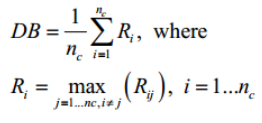
- Measures the average similarity ratio of each cluster with its most similar cluster
- Lower is better (0 is perfect, but unrealistic)
- Good values typically < 1.0
- Considers both cluster compactness (tight clusters) and separation (distance between clusters)
- Formula: Ratio of within-cluster distances to between-cluster distances

##### **Calinski-Harabasz**
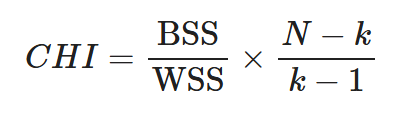
- Ratio of between-cluster variance to within-cluster variance
- Higher is better (more separated clusters)
- No fixed "good" threshold, compare relative values
- Fast to compute, works well with convex clusters
- Tends to favor more clusters than silhouette score

In [ ]:
for k in k_range:
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  
  # Calculate all three metrics
  db_score = davies_bouldin_score(X_scaled, labels)
  ch_score = calinski_harabasz_score(X_scaled, labels)
  
  # Store results
  evaluation_metrics['davies_bouldin'][k] = round(db_score, 3)
  evaluation_metrics['calinski_harabasz'][k] = round(ch_score, 2)

# Determine optimal k based on each metric
optimal_k_db = min(evaluation_metrics['davies_bouldin'], 
                   key=evaluation_metrics['davies_bouldin'].get)
optimal_k_ch = max(evaluation_metrics['calinski_harabasz'], 
                   key=evaluation_metrics['calinski_harabasz'].get)

print("OPTIMAL k VALUES:")
print(f"  Davies-Bouldin Index (lower is better): k = {optimal_k_db}")
print(f"  Calinski-Harabasz Score (higher is better): k = {optimal_k_ch}")

# plot metric visualisations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Davies-Bouldin Index
axes[0].plot(k_range, evaluation_metrics['davies_bouldin'].values(), 
             marker='s', linestyle='-', color='orange', linewidth=2)
axes[0].axvline(optimal_k_db, color='red', linestyle='--', 
                label=f'Optimal k={optimal_k_db}')
axes[0].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[0].set_ylabel("Davies-Bouldin Index", fontsize=12)
axes[0].set_title("Davies-Bouldin Index\n(Lower is Better)", fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(k_range)

# Calinski-Harabasz Score
axes[1].plot(k_range, evaluation_metrics['calinski_harabasz'].values(), 
             marker='^', linestyle='-', color='green', linewidth=2)
axes[1].axvline(optimal_k_ch, color='red', linestyle='--', 
                label=f'Optimal k={optimal_k_ch}')
axes[1].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[1].set_ylabel("Calinski-Harabasz Score", fontsize=12)
axes[1].set_title("Calinski-Harabasz Score\n(Higher is Better)", fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.show()

# create summary DataFrame of metric data
metrics_df = pd.DataFrame(evaluation_metrics)
metrics_df.index.name = 'k'
print("\nMetrics Summary Table:")
metrics_df

#### Silhouette Plot
Measures cluster balance, distribution of silhouette values per cluster, overlap between clusters

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for ax, k in zip(axes, k_range):
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  
  silhouette_vals = silhouette_samples(X_scaled, labels)
  avg_score = silhouette_score(X_scaled, labels)
  
  y_lower = 0
  for i in range(k):
    cluster_vals = silhouette_vals[labels == i]
    cluster_vals.sort()
    y_upper = y_lower + len(cluster_vals)
    
    ax.barh(
      range(y_lower, y_upper),
      cluster_vals,
      height=1
    )
    y_lower = y_upper
  
  ax.axvline(avg_score, color="red", linestyle="--")
  ax.set_xlabel("Silhouette coefficient")
  ax.set_ylabel("Cluster")
  ax.set_title(f"k={k}, avg={avg_score:.3f}")

plt.tight_layout()
plt.show()

### k=***6*** is the best k-value
As concluded from the Elbow Method, Silhouette Score and Silhouette Plot above.

In [ ]:
BEST_K = 6

kmeans = KMeans(n_clusters=BEST_K, random_state=42)
df["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)
df.head()

---

### Hierarchical Clustering

In [ ]:
agglo = AgglomerativeClustering(
  n_clusters=BEST_K,
  linkage="ward"
)

agg_labels = agglo.fit_predict(X_scaled)
df["Cluster_Hierarchical"] = agg_labels

#### Dendrogram with scipy

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
  linkage_matrix,
  truncate_mode='lastp',  # show only last p merged clusters
  p=30,                   # show last 30 merges
  leaf_font_size=10,
  show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram\n(Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=7.5, color='r', linestyle='--', label='Cut at k=6')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Dendrogram Analysis

Ward linkage **minimises within-cluster variance** and is generally well-suited for **customer segmentation**.

Hierarchical merging of clusters
- **Leaves (bottom)** represent one data point each. Labels at the bottom are either individual samples or cluster sizes, depending on how they were truncated(shortened).
- **Vertical lines** shows two clusters being merged. The longer this line, the more dissimilar/further apart the clusters being merged are.
- **Height / Ward distance** indicates distance between merged clusters - substantial vertical jumps between merges suggest natural separations between clusters. 
- **Red line** suggests cutting at k=6 clusters (matching K-Means optimal k)

Conclusion: The dendrogram confirms that 6 clusters (k=6) is best for natural groupings as there is a significant jump in merge distance after this point. This aligns with all our previous tests!

In [ ]:
# extract best KMeans metrics
k = BEST_K
sil_k6 = evaluation_metrics['silhouette'][k]
db_k6  = evaluation_metrics['davies_bouldin'][k]
ch_k6  = evaluation_metrics['calinski_harabasz'][k]

metrics_comparison = pd.DataFrame({
  'Algorithm': ['K-Means', 'Hierarchical'],
  'Silhouette Score': [
    sil_k6,
    silhouette_score(X_scaled, df['Cluster_Hierarchical'])
  ],
  'Davies-Bouldin Index': [
    db_k6,
    davies_bouldin_score(X_scaled, df['Cluster_Hierarchical'])
  ],
  'Calinski-Harabasz Score': [
    ch_k6,
    calinski_harabasz_score(X_scaled, df['Cluster_Hierarchical'])
  ]
})

# print performance statistics for comparison
metrics_comparison = metrics_comparison.round(3)
metrics_comparison

KMeans wins in all 3 metrics: It has a higher Silhouette Score, lower DBI and higher CH score than Hierarchical Clustering.

### Visual Comparison: KMeans VS Hierachical Clustering

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-Means
sns.scatterplot(
  data=df, 
  x='Income (k$)', 
  y='Spending Score (1-99)',
  hue='Cluster_KMeans',
  palette='tab10',
  ax=axes[0],
  alpha=0.6
)
axes[0].set_title(f'K-Means Clustering\nSilhouette: {metrics_comparison.iloc[0]["Silhouette Score"]:.3f}')
axes[0].legend(title='Cluster', fontsize=8)

# Hierarchical
sns.scatterplot(
  data=df,
  x='Income (k$)',
  y='Spending Score (1-99)', 
  hue='Cluster_Hierarchical',
  palette='tab10',
  ax=axes[1],
  alpha=0.6
)
axes[1].set_title(f'Hierarchical Clustering\nSilhouette: {metrics_comparison.iloc[1]["Silhouette Score"]:.3f}')
axes[1].legend(title='Cluster', fontsize=8)

plt.tight_layout()
plt.show()

#### **Conclusion: KMeans is a more suitable algorithm.** We will use KMeans for further visualisations with PCA and t-SNE.

---

### Visualise Clusters with PCA (Principal Component Analysis)

In [ ]:
pca = PCA(n_components=2) # instantiate PCA
X_pca = pca.fit_transform(X_scaled)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15)) # 2rows x 3cols
axes = axes.flatten() # flatten for easy indexing

for idx, k in enumerate(k_range):
  kmeans = KMeans(n_clusters=k, random_state=42) # instantiate kmeans with respective n_clusters
  labels = kmeans.fit_predict(X_scaled)

  # project centroids into PCA space
  centroids_pca = pca.transform(kmeans.cluster_centers_)

  # generate scatter plot in corresponding subplot
  ax = axes[idx]

  # plot cluster points
  scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=0.4, cmap="tab10")

  # plot centroids
  ax.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="black", s=100, marker="X", label="Centroids", alpha=0.8
  )
  ax.set_title(f"k={k}, silhouette={evaluation_metrics["silhouette"][k]:.3f}")
  ax.set_xlabel("PC1")
  ax.set_ylabel("PC2")
  ax.legend()
  print(f"Subplot for k={k} completed.")

plt.tight_layout()
plt.show()

# generate silhouette score summary table
print("PCA achieved an explained variance ratio of ", pca.explained_variance_ratio_)

### Visualise Clusters with t-SNE
t-distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique for visualising high-dimensional data in 2D or 3D.  
It preserves local structure so points that are close in high dimensions remain close in the 2D or 3D plot, making clusters visually meaningful.  

#### How It Works:
* Computes pairwise similarities between points in high-dimensional space.
* Converts them into probabilities (how likely points are neighbours).
* Places points in low-dimensional space (e.g., 2D) such that these neighbour probabilities are preserved.
* Uses t-distribution in 2D to handle crowding (more spread for distant points, tighter for close points).
* Optimises via gradient descent to minimise the difference (KL divergence) between high- and low-dimensional distributions.  
💡 Analogy: Imagine a 3D ball of points — t-SNE “flattens” it onto paper while keeping close friends together.

#### Use k=6
Concluded as the most optimal k-value based on the silhouette score (highest at 0.431) and the elbow method.

In [ ]:
# list of t-SNE configs to compare
tsne_configs = [
  {"perplexity": 30, "learning_rate": 200, "title": "Perplexity 30, LR 200"},
  {"perplexity": 50, "learning_rate": 200, "title": "Perplexity 50, LR 200"},
  {"perplexity": 40, "learning_rate": 100, "title": "Perplexity 40, LR 100"},
]

plt.figure(figsize=(18, 5))

for i, cfg in enumerate(tsne_configs, 1):
  tsne = TSNE(
    n_components=2,
    perplexity=cfg["perplexity"],
    learning_rate=cfg["learning_rate"],
    random_state=42
  )
  X_tsne = tsne.fit_transform(X_scaled)
  
  plt.subplot(1, len(tsne_configs), i)
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["Cluster_KMeans"], alpha=0.6, cmap="tab10")
  plt.title(cfg["title"])
  plt.xlabel("t-SNE 1")
  plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

Check by:
- Looking for plots where clusters are most clearly separated and compact.
- Avoiding plots where clusters overlap heavily or look scattered randomly.
- Check consistency: run t-SNE a few times (random_state fixed for reproducibility) — prefer the configuration where clusters consistently separate.

Perplexity 50, LR 200 shows the most distinct and compact clustering with minimal overlapping.

---

## **STAGE 5: Conclusion**

### Interpret Customer Segmentation
* **Cluster DataFrame**: Analytic Segmentation
* **Radar Chart**: Visual Segmentation

In [ ]:
cluster_means = df.groupby("Cluster_KMeans")[features].mean()
cluster_means

In [ ]:
# normalize features for radar chart (0-1 scale)
cluster_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

categories = list(cluster_norm.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1] # complete the loop

# setup subplots
num_clusters = cluster_norm.shape[0]
cols = 3
rows = (num_clusters + 1) // cols

plt.figure(figsize=(cols*4, rows*4))

for i, (cluster_id, row) in enumerate(cluster_norm.iterrows(), 1):
  values = row.tolist()
  values += values[:1] # complete the loop
  
  ax = plt.subplot(rows, cols, i, polar=True)
  ax.plot(angles, values, label=f"Cluster {cluster_id}", color=f"C{cluster_id}")
  ax.fill(angles, values, alpha=0.2, color=f"C{cluster_id}")
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(categories)
  ax.set_ylim(0, 1)
  ax.set_title(f"Cluster {cluster_id}", size=12)

plt.tight_layout()
plt.show()

cluster_means

---

## **Interpretation of Customer Segments**

#### Data Context / Recap on Dataset:
1. Mean Age ≈ **39 years old**

2. Mean Income ≈ **$60.6k**

3. Spending Score reflects **spending tendency**, not affordability

<br>

---

##### **Cluster 0: Old Balanced Shoppers**

Statistics
- Age: ~56.3 (oldest cluster)
- Income: ~$54.3k (slightly below average)
- Spending Score: ~49.1 (moderate)

Characteristics:
1. Stable and needs-driven purchasing behaviour
2. Spending aligns reasonably with income
3. Likely values utility, reliability, and consistency

Business implication: Reliable but limited growth potential. More suited for **retention-focused strategies**.
##### **Cluster 1: Young & Rich Splurgers**

Statistics
- Age: ~32.7 (younger than average)
- Income: ~$86.5k (well above average)
- Spending Score: ~82.1 (very high)

Characteristics:
1. Strong purchasing power combined with high willingness to spend
2. High engagement with discretionary and premium products
3. Likely lifestyle-oriented and experience-driven consumers

Business implication: Highest revenue potential. Key target for **premium offerings, upselling, and loyalty programmes**.


##### **Cluster 2: Young & Impulsive Splurgers**

Statistics
- Age: ~25.6 (youngest cluster)
- Income: ~$26.5k (lowest income)
- Spending Score: ~76.2 (high)

Characteristics:
1. Spending behaviour is disproportionate to income level
2. Likely impulsive or trend-driven purchasing behaviour
3. Financially vulnerable but highly engaged consumers

Business implication: High short-term engagement potential, but requires **careful positioning** to avoid churn or financial strain.


##### **Cluster 3: Cautious Shoppers**

Statistics
- Age: ~26.1 (young)
- Income: ~$59.4k (near average)
- Spending Score: ~44.5 (moderate–low)

Characteristics:
1. Financially capable but spending-conscious
2. Likely to compare prices and delay purchase decisions
3. Rational, value-for-money oriented consumers

Business implication: Responsive to **discounts and clear value propositions**, with moderate growth potential.


##### **Cluster 4: Rich but Frugal Middle-Aged Shoppers**

Statistics
- Age: ~44.0
- Income: ~$90.1k (highest among all clusters)
- Spending Score: ~17.9 (lowest)

Characteristics:
1. Strong financial capacity but minimal discretionary spending
2. Likely prioritises savings or long-term financial security
3. Highly selective and deliberate purchasing behaviour

Business implication: Difficult to activate; requires **trust-based, long-term value messaging** rather than short-term promotions.


##### **Cluster 5: Ghost Shoppers (Low-Engagement)**

Statistics
- Age: ~45.5
- Income: ~$26.3k (low)
- Spending Score: ~19.4 (very low)

Characteristics:
1. Low purchasing power combined with low engagement
2. Minimal participation in discretionary consumption
3. Likely prioritises essential spending only

Business implication: Lowest return on investment; **not a strategic focus for growth**.

<br>

---

#### **"Q: Which Cluster Needs the Most Attention?"**

##### A: Cluster 4 "Rich but Frugal Middle-Aged"

- Highest income but lowest spending - why? They definitely have the capacity to spend more, yet they don't, showcasing huge untapped potential for the business. This strongly suggests that existing business strategies are likely ineffective for this customer segment - I investigate more below.

- After inspecting the age range of the clusters with the highest and lowest spending, here's what I found:
  1. Clusters 1 & 2 have the highest Spending. The mean age of customers in these groups is ~29years.
  2. In contrast, Cluster 4 has the 2nd lowest Spending. The mean age of customers in this group is 44years.
  
  - The age gap is nearly 15years! This validates my hypothesis that the strategies employed are either too generalised or only effective for a younger audience (25-35years old).

- Solution: **Devise marketing campaigns or strategies targeted at the middle-aged**. It is crucial to draw on this pool of untapped revenue to maximise business growth.

<br>

##### Secondary Opportunity: Cluster 1 "Young & Rich Splurgers"

- High engagement and spending is not guaranteed over time - factors like customer dissatisfaction, evolving needs and business relevance can cause businesses to lose loyal customers. It is up to the business to utilise smart strategies to maintain customer loyalty. Methods include but are not limited to: showing customers appreciation via loyalty programs, exclusive benefits (e.g. early access to new products).

- The customers in this segment are ~33years old. However, the **age group is not a big consideration for the strategy as the focus is on minimising churn** (rate at which customers stop doing business with a company).

- Since the average income of this customer group is exceptionally high, we should leverage their high SES (socio-economic status) to benefit not just the business, but the customers too. The business can organise invite-only connection dinners to give customers opportunities to expand their network if they continue to contribute to our business. **This adds an unique dimension to the loyalty programme by delivering value beyond transactions, aligning long-term customer wellbeing with the business strategy.**

- Solution: A **combination of loyalty programs and exclusive benefits** will be the smoothest and most effective way to retain this valuable group of customers.

<br>

#### **"Q: How I performed customer segmentation using unsupervised machine learning algorithms in Python?"**

##### A:

First, I conducted exploratory data analysis (EDA) to understand the distribution and relationships between key variables such as age, income, and spending score. This helped identify potential patterns and informed subsequent preprocessing steps.

Next, I carried out data preprocessing and feature engineering, which included scaling numerical features using StandardScaler to ensure fair distance-based clustering and preparing the dataset for dimensionality reduction and clustering algorithms.

I then applied multiple clustering algorithms, specifically K-Means and Agglomerative Clustering, to avoid relying on a single method and to validate the robustness of the segmentation results.

To determine the optimal number of clusters (k), I evaluated a range of k-values using several quantitative metrics:

Elbow Method to analyse within-cluster variance

Silhouette Score and Silhouette Plot to assess cluster separation and cohesion

Davies–Bouldin Index and Calinski–Harabasz Score to compare clustering quality across k-values

Based on the consistency of these metrics, I selected the best-performing value of k (k=6).

To test and visualise clustering behaviour, I used:

Initially, 2D scatter plots to visually compare clustering outcomes. But I realised the visuals weren't very accurate as I trained my model using 3 dimensions.

So I used PCA for 2D visualisation across different k-values

And t-SNE with varying perplexities and learning rates to inspect non-linear separability

Hierarchical clustering dendrograms were also used to examine cluster structure and validate k selection

Finally, I interpreted the resulting clusters by analysing cluster-level statistics and behavioural patterns, translating them into meaningful customer segments with clear business implications.

<br>

_by JEROME LOKE | DAAA/FT/1B/01 | P2510707_